## Tasks

### 1. Preliminary analysis

| Task    | Assigned to | Status |
|:----------------|:------------|:------:|
| What type of documents does it contain?  | Alberto | ✅ |
|       How many documents are there?       | Alberto | ✅ |
|       Calculate and visualise some simple statistics for the collection, e.g. the average document length, the average vocabulary size, etc.       | Tutti | ❌ |
|    BIO tagging for each file.       | Paolo | ✅ |
| Create datasets with sentences from the tagged dataset. | Paolo | ✅ |
| Create merged datasets | Paolo | ✅ |
| Cluster the documents and visualise the clusters to see what types of groups are present | Paolo | ❌ |
| Index the documents so that you can perform keyword search over them | Leonardo | ❌ |
| Train a Word2Vec embedding on the data and investigate the properties of the resulting embedding | Alberto | ❌ |


> **_KEY:_** [✅]() Completed [❌]() Not Completed

### 2. Training models

| Task    | Assigned to | Status |
|:----------------|:------------|:------:|
| Train a model to perform that task (by fine-tuning models on the training data)  | ??? | ❌ |
| Test pre-trained models on the task (if they already exist)                      | ??? | ❌ |
| Evaluate different models and compare their performance                          | ??? | ❌ |
> **_KEY:_** [✅]() Completed [❌]() Not Completed

> **_HINT_**: as a minimum here we would expect to see a linear classifier trained on the data (if an
appropriate for the task) and compare it with deep learning model, such as BERT.

### 3. Possible extensions:
Depending on the dataset chosen there will be many additional investigations you can perform.
For instance, oftentimes we can improve performance of a model on a particular task by simply
including additional data that is related to the task in its training set. So see if you can find other
data that helps with the task that you chose. Moreover, there are many NLP challenges out
there, so if you can’t find more data for the task you’re working on, look for another interesting
challenge to work on.

## Libraries

In [1]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import random
import numpy as np
import plotly.express as px
import sys
import spacy
import it_core_news_sm
import csv
import os

from nltk.corpus import stopwords
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm

/home/paolo/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/MyDrive/Colab Notebooks/NLP/KIND-main')
    os.getcwd()

    print("Colab environment detected. Paths have been set.")
else:
    print("You are not running in Google Colab. Skipping this step...")

You are not running in Google Colab. Skipping this step...


## Data Import

In the following section we manipulate the dataset provided to get the full sentences that have been annotated by the original authors.

First we create the directories if they do not exist.

In [3]:
os.mkdir(os.path.join(os.getcwd(), 'dataset')) if not os.path.exists(os.path.join(os.getcwd(), 'dataset')) else None
os.mkdir(os.path.join(os.getcwd(), 'dataset/txt-version')) if not os.path.exists(os.path.join(os.getcwd(), 'dataset/txt-version')) else None
os.mkdir(os.path.join(os.getcwd(), 'dataset/BIO-tagged-version')) if not os.path.exists(os.path.join(os.getcwd(), 'dataset/BIO-tagged-version')) else None

### Merged dataset generation

We want to provide an additional dataset in which content of all the files is merged together. This will be useful for the subsequent tasks.

First we merge the initial `.tsv` train files:

In [4]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_files = os.listdir(dataset_dir)

# Merging all train.tsv files together.
content = ""
for file in tqdm(dataset_files):
    # We are dealing with the train.tsv files only.
    if file.endswith('test.tsv') or not file.endswith('.tsv'):
        continue

    file_path = os.path.join(dataset_dir, file)  

    # Read the content of the file and appending it to the content variable.
    with open(file_path, 'r') as f:
        content += f.read()
    
# Write the merged content back to the file
with open(f'{dataset_dir}/merged_dataset_train.tsv', 'w') as f:
    f.write(content)

100%|██████████| 10/10 [00:00<00:00, 335.01it/s]


Now we do the same for the test files:

In [5]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_files = os.listdir(dataset_dir)

# Merging all train.tsv files together.
content = ""
for file in tqdm(dataset_files):
    # We are dealing with the train.tsv files only.
    if file.endswith('train.tsv') or not file.endswith('.tsv'):
        continue

    file_path = os.path.join(dataset_dir, file)  

    # Read the content of the file and appending it to the content variable.
    with open(file_path, 'r') as f:
        content += f.read()
    
# Write the merged content back to the file
with open(f'{dataset_dir}/merged_dataset_test.tsv', 'w') as f:
    f.write(content)

100%|██████████| 11/11 [00:00<00:00, 2216.01it/s]


### Complete sentences generation

Now for each train and test `.tsv` file we want to retrieve the compact form of the sentences that have been annotated by the original authors.

For each file, sentences have been reconstructed and allocated one-for-row in the corresponding `.txt` file.

In [6]:
# Get the list of files in the dataset directory
dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_files = os.listdir(dataset_dir)

# For each file in the dataset directory split the content when finding empty lines.
for file in tqdm(dataset_files):
    # Do not read txt files.
    if not file.endswith('.tsv'):
        continue

    # Get the .tsv file path
    file_path = os.path.join(dataset_dir, file)

    # Inserting the content of the tsv file into a dataframe keeping the blank lines (i.e. the end of a sentence).
    data_df = pd.read_csv(file_path, sep='\t', names=['Word', 'Entity'], skip_blank_lines=False, quoting=csv.QUOTE_NONE)

    # Replace NaN values with a new line (\n) to mark the beginning of a new phrase.
    data_df.fillna('\n', inplace=True)
    
    # Reconsetructing the sentences by joining the words together.
    sentences = " ".join(data_df['Word']).replace('\n ', '\n') #.replace(' .', '.').replace(' ,', ',').replace(' !', '!').replace(' ?', '?').replace(' :', ':').replace(' ;', ';').replace(' %', '%').replace(' )', ')').replace('( ', '(').replace(' ]', ']').replace('[ ', '[').replace(' }', '}').replace('{ ', '{')
    
    # Write the content back to a text file.
    output_file_path = f"{os.path.join(os.getcwd(), 'dataset/txt-version')}/{file[:-3] + 'txt'}"
    with open(output_file_path , 'w') as f:
        f.write(sentences)

100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


### Bio tagging conversion

Finally, we convert into BIO-tagging format the entities in the datasets.

In [7]:
o_tag = "O"
types = set()
count = {}

# Dictionary of input and output files names.
files = {
	"wikinews_train.tsv": "WN_train.tsv",
	"wikinews_test.tsv": "WN_test.tsv",
	"fiction_train.tsv": "FIC_train.tsv",
	"fiction_test.tsv": "FIC_test.tsv",
	"degasperi_train.tsv": "ADG_train.tsv",
	"degasperi_test.tsv": "ADG_test.tsv",
	"moro_train.tsv": "AM_train.tsv",
	"moro_test.tsv": "AM_test.tsv",
	"merged_dataset_train.tsv": "MERGED_train.tsv",
	"merged_dataset_test.tsv": "MERGED_test.tsv",
}

for file in tqdm(files):
	with open(f"{os.path.join(os.getcwd(), 'dataset')}/{file}", "r") as f:
		# Getting the output file name related to the current file.
		out_file = files[file]
		count[out_file] = {"sentences": 0, "tags": {}, "tokens": 0}

		sentences = []
		current_sentence = []

		for line in f:
			line = line.strip()
			if len(line) == 0:
				if len(current_sentence) > 0:
					sentences.append(current_sentence)
					current_sentence = []
				continue
			parts = line.split("\t")
			current_sentence.append(parts)
			count[out_file]["tokens"] += 1

		if len(current_sentence) > 0:
			sentences.append(current_sentence)

		count[out_file]["sentences"] = len(sentences)

		# BIO tagging conversion. The first non-O tag after a sequence of O-tags is converted to B-tag.
		# The following non-O tags (the ones that follow the B-tag) are converted to I-tags until
		# an O-tag is found. The same procedure is repeated for each sequence of non-O tags.
		for sentence in sentences:
			previous_ner = o_tag
			for token in sentence:
				ner = token[1]
				new_ner = ner
				if ner != o_tag:
					if previous_ner != ner:
						if ner not in count[out_file]["tags"]:
							count[out_file]["tags"][ner] = 0
						new_ner = "B-" + ner
						count[out_file]["tags"][ner] += 1
						types.add(ner)
					else:
						new_ner = "I-" + ner
				token[1] = new_ner
				previous_ner = ner

		# Writing the converted file into the appropriate directory.
		with open(f"{os.path.join(os.getcwd(), 'dataset/BIO-tagged-version')}/{out_file}", "w") as fw:
			for sentence in sentences:
				for token in sentence:
					fw.write(token[0])
					fw.write("\t")
					fw.write(token[1])
					fw.write("\n")
				fw.write("\n")

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


## Data inspection

KIND (Kessler Italian Named-entities Dataset) is an Italian dataset for Named-Entity Recognition (NER).

The purpose of NER task is to tag all the named entity, namely identify all the objects in the real world.

In this case there are three categories to annotate:
- person (PER): a single individual, an animal or a group of humans with a proper name;
- organization (ORG): every formally established association defined by an organizational structure;
- location (LOC): geographical entities defined by political and/or social groups which possess a physical location and a proper name.

The dataset is composed by four different collections with texts taken from: 
- Wikinews (WN) as a source of news texts, picking articles belonging to the last two decades; 
- Italian fiction books (FIC) in the public domain ; 
- writings and speeches from Italian politician Aldo Moro (AM);
- public documents written by Alcide De Gasperi (ADG).

The texts belong to three different domains: news, literature, and political discourses.

The dataset contains more than one million tokens, of which around 600K are manually annotated instead the remaining part is semi-automatically annotated.

| Dataset   | Documents |
| --------- | --------- |
| Wikinews  | 1,000 |
| Fiction | 86 |
| Aldo Moro | 250 |
|Alcide De Gasperi | 158 |

In [8]:
# each row of the dataframe is a word with associated type of entity
data_df = pd.read_csv('dataset/degasperi_train.tsv', sep='\t', names=['word', 'entity'])

In [9]:
# see first elements
data_df.head()

,word,entity
0,Il,O
1,ministro,O
2,degli,O
3,Esteri,O
4,al,O


In [10]:
# all elements are not null
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123504 entries, 0 to 123503
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   word    123504 non-null  object
 1   entity  123504 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [11]:
# there are 123504 words
data_df.describe()

,word,entity
count,123504,123504
unique,15449,4
top,",",O
freq,6200,118933


In [12]:
data_df[:25]

,word,entity
0,Il,O
1,ministro,O
2,degli,O
3,Esteri,O
4,al,O
5,commissario,O
6,capo,O
7,della,O
8,Commissione,ORG
9,alleata,ORG


In [19]:
counts_entity = Counter(data_df['entity'])
print(counts_entity)

Counter({'O': 118933, 'ORG': 2396, 'PER': 1129, 'LOC': 1046})


<BarContainer object of 4 artists>

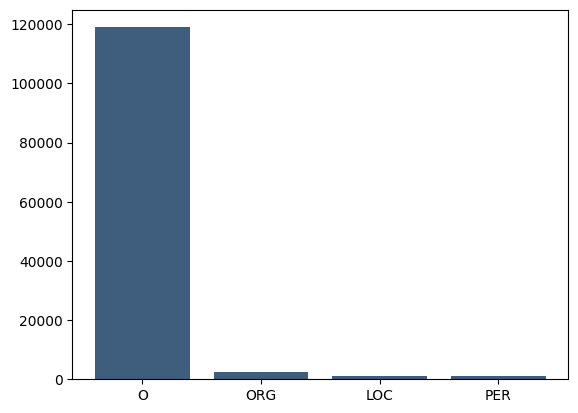

In [20]:
plt.bar(counts_entity.keys(), counts_entity.values(), color="#3F5D7D", width=0.8)
# there is a huge unbalance between the 'O' class and the others

In [ ]:
counts_word = Counter(data_df['word'])
print(counts_word)

Counter({',': 6200, '.': 3792, 'di': 3664, 'e': 3101, 'che': 3045, 'la': 2240, 'il': 2018, 'in': 1299, 'del': 1281, 'non': 1258, 'è': 1234, 'per': 1229, "l'": 1197, 'a': 1194, 'della': 1123, 'si': 1121, 'i': 966, 'un': 915, 'le': 859, 'una': 789, 'dei': 656, 'al': 554, 'con': 546, 'da': 505, 'più': 494, 'delle': 485, 'alla': 478, "dell'": 476, 'ha': 473, 'ma': 454, 'anche': 413, ':': 400, ';': 394, 'come': 371, '»': 358, '«': 357, 'o': 350, 'sono': 349, 'gli': 348, 'nel': 348, '–': 322, 'ed': 319, "d'": 303, 'ad': 298, 'Il': 296, 'se': 294, 'questo': 293, 'nella': 285, '?': 272, 'ci': 261, 'governo': 257, ')': 253, 'loro': 248, 'noi': 246, 'lo': 244, 'essere': 237, 'perché': 234, "all'": 232, 'ai': 225, 'questa': 224, '(': 217, 'tutti': 214, 'dal': 210, 'contro': 206, 'sia': 203, 'cui': 197, 'degli': 193, 'suo': 191, 'La': 191, 'parte': 191, 'hanno': 186, 'nostra': 181, 'sua': 180, 'Ma': 178, 'quale': 178, 'Italia': 178, 'partito': 177, 'nostro': 175, 'politica': 171, 'alle': 170, 'anc

There are three classes: person (PER), location (LOC) and organization(ORG).

The tag 'O' is used when a word is not a named entity.

In [ ]:
# retrieve all words with label 'PER'
persons = data_df.loc[data_df['entity'] == 'PER', 'word']
persons_set = set(persons)
print(f'There are {len(persons_set)} different words labelled as PER')
sorted(persons_set)[:10]

There are 412 different words labelled as PER


['A.',
 'Achille',
 'Adami',
 'Adenauer',
 'Adler',
 'Aehrenthal',
 'Agnesi',
 'Agostino',
 'Alcide',
 'Alessio']

In [ ]:
# retrieve all words with label 'LOC'
locations = data_df.loc[data_df['entity'] == 'LOC', 'word']
locations_set = set(locations)
print(f'There are {len(locations_set)} different words labelled as LOC')
sorted(locations_set)[:10]

There are 304 different words labelled as LOC


['10',
 'Adige',
 'Adria',
 'Adriatico',
 'Africa',
 'Aia',
 'Aja',
 'Ala',
 'Aldeno',
 'Aldobrandini']

In [ ]:
# retrieve all words with label 'ORG'
organizations = data_df.loc[data_df['entity'] == 'ORG', 'word']
organizations_set = set(organizations)
print(f'There are {len(organizations_set)} different words labelled as ORG')
sorted(organizations_set)[:10]

There are 521 different words labelled as ORG


['(uniti)',
 '5ª',
 'Adige',
 'Agricoltura',
 'Aja',
 'Alleate',
 'Alleati',
 'Alleato',
 'Alpine',
 'Alto']

In [ ]:
# obtain a string text with all the words
text = " ".join(data_df['word'])

print(text[:151])

Il ministro degli Esteri al commissario capo della Commissione alleata Sono informato che l' ordine n. 14 , emesso il 10 settembre dal Governo Militare


In [ ]:
print(f'The length of the text is {len(text)} characters')

The length of the text is 717924 characters


In [ ]:
# obtain all the sentences
sentences = re.split('[?!.]\s', text)

print(f'There are {len(sentences)} sentences')
sentences[:5]

There are 4486 sentences


["Il ministro degli Esteri al commissario capo della Commissione alleata Sono informato che l' ordine n",
 "14 , emesso il 10 settembre dal Governo Militare Alleato di Trieste che istituisce speciali « carte d' identità » per le persone che vivono nella « Zona A » , è giunto nella fase dell' applicazione pratica ",
 'Sono in possesso del testo italiano di detto ordine , soltanto come stampato nei quotidiani di Trieste ( vedi allegato ) ',
 'Mi consenta , caro Ammiraglio Stone , di esporle brevemente alcune impressioni e alcune preoccupazioni relative a tale ordine che mi sono giunte da varie fonti da esso toccate ',
 "L' ordine n"]

## Vocabulary

In [ ]:
regex = '[' + string.punctuation + ']'
print(regex)

# remove all the punctuation (probably not necessary)
text_no_punctuation = re.sub(regex,'',text)
print(text_no_punctuation[:151])

[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]
Il ministro degli Esteri al commissario capo della Commissione alleata Sono informato che l ordine n 14  emesso il 10 settembre dal Governo Militare Al


In [ ]:
print(f'The length of the text with punctuation is {len(text)} characters')
print(f'The length of the text without punctuation is {len(text_no_punctuation)} characters')
print(f'{len(text) - len(text_no_punctuation)} characters are removed')

The length of the text with punctuation is 717924 characters
The length of the text without punctuation is 702320 characters
15604 characters are removed


In [ ]:
# build vocabulary
# convert to lowercase, split on whitespace, select only distinct words, sort the words alphabetically
words = text_no_punctuation.lower().split()
vocabulary = sorted(set(words))
print(f'The vocabulary contains {len(vocabulary)} words')
print(vocabulary)

The vocabulary contains 14395 words
['0', '1', '10', '100', '10859554', '11', '12', '120', '127', '128', '13', '131', '14', '143', '1456', '15', '156', '16', '160', '1644231', '167', '17', '170', '1700', '18', '1814', '1848', '1879', '1881', '1882', '1890', '1892', '19', '1900', '1903', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1918', '1919', '1920', '192021', '1921', '1922', '1923', '1924', '1939', '1943', '1944', '1945', '1946', '194654', '1947', '194748', '1948', '1949', '195051', '1951', '1952', '1953', '1992', '1°', '2', '20', '200', '20000', '2021', '207', '21', '210', '22', '221', '2295', '23', '230', '2315', '2345', '238', '24', '25', '26', '27', '2730', '28', '29', '3', '30', '300', '31', '33', '344', '346486', '347', '35', '36', '362', '363', '38', '380', '381', '395', '4', '40', '400', '407', '41', '45', '4600', '48', '49', '5', '50', '51', '52', '53', '55', '557', '5657', '58', '580', '591', '5ª', '6', '60', '61', '6122638', '62', '625', '65', '651', '69', '6

In [ ]:
# build vocabulary using CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences)

print(f'The vocabulary contains {len(vectorizer.get_feature_names_out())} words')
vectorizer.get_feature_names_out()[:20]

The vocabulary contains 14299 words


array(['10', '100', '11', '12', '120', '122', '128', '13', '14', '143',
       '1456', '15', '156', '16', '160', '1644', '167', '17', '170',
       '1700'], dtype=object)

In [ ]:
nltk.download('stopwords')

print('Italian stopwords:')
print(stopwords.words('italian'))

Italian stopwords:
['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# build vocabulary by removing italian stop words and with words with at least 3 occurences
vectorizer = CountVectorizer(min_df=3, stop_words=stopwords.words('italian'))
vectorizer.fit(sentences)
print(f"vocabulary size: {len(vectorizer.get_feature_names_out())}")

vocabulary size: 4090


## Word embeddings

Clean the data: 
- remove non-letter characters from each sentence 
- lowercase 
- tokenize the sentences based on whitespace
- remove any sentence with length less than 2 since it won't be useful for training Word2Vec. 

In [ ]:
# maybe don't remove punctuation
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['il', 'ministro', 'degli', 'esteri', 'al', 'commissario', 'capo', 'della', 'commissione', 'alleata', 'sono', 'informato', 'che', 'l', 'ordine', 'n']
['14', 'emesso', 'il', '10', 'settembre', 'dal', 'governo', 'militare', 'alleato', 'di', 'trieste', 'che', 'istituisce', 'speciali', 'carte', 'd', 'identità', 'per', 'le', 'persone', 'che', 'vivono', 'nella', 'zona', 'a', 'è', 'giunto', 'nella', 'fase', 'dell', 'applicazione', 'pratica']
['sono', 'in', 'possesso', 'del', 'testo', 'italiano', 'di', 'detto', 'ordine', 'soltanto', 'come', 'stampato', 'nei', 'quotidiani', 'di', 'trieste', 'vedi', 'allegato']
['mi', 'consenta', 'caro', 'ammiraglio', 'stone', 'di', 'esporle', 'brevemente', 'alcune', 'impressioni', 'e', 'alcune', 'preoccupazioni', 'relative', 'a', 'tale', 'ordine', 'che', 'mi', 'sono', 'giunte', 'da', 'varie', 'fonti', 'da', 'esso', 'toccate']
['l', 'ordine', 'n']
['14', 'è', 'senza', 'dubbio', 'una', 'misura', 'importante', 'per', 'le', 'conseguenze', 'che', 'potrebbero', 'deri

Train Word2Vec.

Parameters:
- embedding size = 30,
- minimum count for any vocabulary term = 1
- size of the context window = 10.

In [ ]:

model = Word2Vec(tokenized_sentences, vector_size=30, min_count=1, window=10)

In [ ]:
print(f'There are {len(model.wv)} word embeddings')

There are 14307 word embeddings


In [ ]:
term = 'italia'
model.wv[term]

array([-0.47051552, -1.0478009 ,  2.2168615 ,  0.0954624 ,  0.29520038,
       -0.58258826,  1.4845263 ,  0.7696925 , -2.2451346 ,  0.5109411 ,
        1.9720718 ,  0.9078727 ,  0.08624078, -1.379463  , -0.26344252,
       -0.5452036 ,  0.9988756 ,  0.3020259 , -1.6448991 ,  0.66243297,
        0.10312375, -0.19492187,  0.35199526,  1.5910323 ,  0.6628034 ,
        0.95477587,  0.88236195,  1.1746914 ,  0.96463054, -2.509163  ],
      dtype=float32)

In [ ]:
term ='italia'

model.wv.most_similar(term)

[('come', 0.99970942735672),
 ('ed', 0.9996994137763977),
 ('dal', 0.9996888041496277),
 ('quanto', 0.9996781349182129),
 ('nell', 0.9996741414070129),
 ('deve', 0.9996524453163147),
 ('se', 0.9996485114097595),
 ('nel', 0.999645471572876),
 ('all', 0.9996419548988342),
 ('più', 0.9996419548988342)]

In [ ]:
# properties are not valid, probably because the dataset is too small
vec = model.wv['roma'] + (model.wv['francia'] - model.wv['italia'])  

model.wv.similar_by_vector(vec)

[('condizionata', 0.7185835242271423),
 ('messaggero', 0.6700010895729065),
 ('inclina', 0.6094666123390198),
 ('riflessi', 0.6041065454483032),
 ('tecnico', 0.5941399335861206),
 ('doti', 0.5658515691757202),
 ('passerà', 0.558567225933075),
 ('sottoposti', 0.5565853118896484),
 ('verifica', 0.5465562343597412),
 ('contesto', 0.5439687371253967)]

In [ ]:
# sample 500 random word embeddings
sample = random.sample(list(model.wv.key_to_index), 300)
word_vectors = model.wv[sample]

# visualize word embeddings using TSNE
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

## spaCy

In [ ]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


There is also the large version https://spacy.io/models/it

In [ ]:
!{sys.executable} -m spacy download it_core_news_sm;

2023-04-28 15:22:36.398902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 15:22:37.365027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 98.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [ ]:
nlp_model = it_core_news_sm.load()

In [ ]:
text_spacy = text[:151]
parsed_text = nlp_model(text_spacy)
print(parsed_text)

Il ministro degli Esteri al commissario capo della Commissione alleata Sono informato che l' ordine n. 14 , emesso il 10 settembre dal Governo Militare


In [ ]:
print(f'The length of the original text is {len(text_spacy)} characters')
print(f'The length of the parsed text is {len(parsed_text)} words')

The length of the original text is 151 characters
The length of the parsed text is 26 words


In [ ]:
parsed_text.ents

(Esteri, Commissione, Governo Militare)

In [ ]:
print([(ent.text, ent.label_) for ent in parsed_text.ents])

[('Esteri', 'LOC'), ('Commissione', 'ORG'), ('Governo Militare', 'ORG')]


In [ ]:
[(X, X.ent_iob_, X.ent_type_) for X in parsed_text]

[(Il, 'O', ''),
 (ministro, 'O', ''),
 (degli, 'O', ''),
 (Esteri, 'B', 'LOC'),
 (al, 'O', ''),
 (commissario, 'O', ''),
 (capo, 'O', ''),
 (della, 'O', ''),
 (Commissione, 'B', 'ORG'),
 (alleata, 'O', ''),
 (Sono, 'O', ''),
 (informato, 'O', ''),
 (che, 'O', ''),
 (l, 'O', ''),
 (', 'O', ''),
 (ordine, 'O', ''),
 (n., 'O', ''),
 (14, 'O', ''),
 (,, 'O', ''),
 (emesso, 'O', ''),
 (il, 'O', ''),
 (10, 'O', ''),
 (settembre, 'O', ''),
 (dal, 'O', ''),
 (Governo, 'B', 'ORG'),
 (Militare, 'I', 'ORG')]

In [ ]:
from spacy import displacy
displacy.render(parsed_text, jupyter=True, style='ent')